# Scenario Building

In [266]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import time
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from kneed import KneeLocator

#make plot default more academic (bold axis, etc)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 12


In [267]:
#import the necessary data
# Load the simulated load data
sim_data = pd.read_csv('SNI_Load.csv')
# Load the solar and wind data
solar_data = pd.read_csv('solarfinal.csv')
wind_data = pd.read_csv('Windfinal2.csv')
kwperturbine = 100 #kW
#make nuclear data with the same first column and a second column ('kWh') of matching length with repeated 1000s
nuclear_data = pd.DataFrame(sim_data['Date'])
nuclear_data['kWh'] = 1000.0 #set the eletrical capacity of the nuclear plant 

sim_data.set_index('Date', inplace=True)
solar_data.set_index('Date', inplace = True)
wind_data.set_index('Date', inplace = True)
nuclear_data.set_index('Date', inplace = True)
#convert all indices to datetime
sim_data.index = pd.to_datetime(sim_data.index)
solar_data.index = pd.to_datetime(sim_data.index)
wind_data.index = pd.to_datetime(sim_data.index)
nuclear_data.index = pd.to_datetime(sim_data.index)

demand = sim_data['kWh']
batteff = .90

#print max demand
print(demand.max())
print(demand.min())

753.0
362.0


In [268]:
#Diesel function
def calculate_diesel(unmet_demand):
    diesel = []
    fuel = []
    i  = unmet_demand
    opcap = 500
    coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve

    def galcalc(opcap, op):
        outp = op/opcap*100
        eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
        kwh = op/eff
        gal = kwh/37.5
        return gal

    p = np.poly1d(coeffs)
    if i > -.001:
        diesel = (0)
        fuel = (0)
    else:
        if i > -250:
            diesel = 250
            opcap = 825
            fuel = galcalc(opcap, 250)
        elif i > -825:
            diesel = (-i)
            opcap = 825
            fuel = (galcalc(opcap, -i))
        elif i > -1000:
            opcap = 1000
            diesel = (-i)
            fuel = (galcalc(opcap, -i))
        elif i > -1000:
            opcap = 1000
            diesel = (-i)
            fuel = (galcalc(opcap, -i))
        else:
            opcap = 10000
            diesel = (-i)
            fuel = (galcalc(opcap, -i))

    return diesel, fuel

In [269]:
#Energy Simulation Function
def simulate_energy(scenario):
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battpower = scenario[3]
    battcap = scenario[4]*.6 #Depth of discharge relegated from 80% to 20% to increase battery life
    dieselstatus = scenario[5]
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
  
    supplytotal = wind + solar + nuclear
    #power system calculation
    #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    diesel = []
    fuel = []
    curtail = 0
    for i in supplytotal - demand:
            icharge = charge
            if i > 0.0000001:
                if i > battpower:
                    charge = charge + battpower*batteff
                    curtail = i-battpower
                else:
                    charge = charge + i*batteff
                    curtail = 0 
                if charge > battcap:
                    curtail = curtail + charge - battcap
                    charge = battcap
                battery.append(charge)
                discharge.append(0)
                curtailed.append(curtail)
                diesel.append(0)
                fuel.append(0)
            else:
                if dieselstatus == 0:
                    if i < -battpower:
                        charge = charge - battpower
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(battpower*batteff)
                    else:
                        charge = charge + i/batteff
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(-i)
                    battery.append(charge)
                    curtailed.append(0)
                    diesel.append(0)
                    fuel.append(0)
                else:
                    if i < -battpower:
                        charge = charge - battpower
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(battpower*batteff)
                    else:
                        charge = charge + i/batteff
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(-i)
                    battery.append(charge)
                    if i+discharge[-1] >= 0-.0000001:
                        diesel.append(0)
                        fuel.append(0)
                    else:   
                        dieseln, fueln = calculate_diesel(i+discharge[-1])
                        fuel.append(fueln)
                        diesel.append(dieseln)
                        if dieseln + i +discharge[-1] > 0-.0000001 and discharge[-1] > 0:
                            discharge[-1] = discharge[-1]-(discharge[-1]+dieseln + i)
                            battery[-1] = battery[-1] + discharge[-1] + dieseln + i
                    curtailed.append(0)
                #if diesel[-1] + i + discharge[-1]> 0-.00000001 and diesel[-1] != 0:
                    #curtailed[-1] = diesel[-1] + i+ discharge[-1]

        # Calculate the total supply
    supplytotal = wind + solar + nuclear + discharge + diesel

    

    fuel_data = pd.DataFrame(sim_data.index)
    fuel_data['gal'] = fuel
    fuel_data.set_index('Date', inplace = True)
    fuel_data = fuel_data.round(2)
    #make fuel data cumulative
    fuel_data['cumulative'] = fuel_data['gal'].cumsum()

    fuel = np.array(fuel_data['cumulative'])

    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)
    
    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    #create the curtailed DataFrame
    curtailed = np.array(curtailed)
    curtailed_data = pd.DataFrame(sim_data.index)
    curtailed_data['kWh'] = curtailed
    curtailed_data.set_index('Date', inplace = True)
    #make curtailed data cumulative
    curtailed_data['cumulative'] = curtailed_data['kWh'].cumsum()
    curtailedcum = np.array(curtailed_data['cumulative'])
    
    count = 0
    for s, d in zip(supplytotal, demand):
        if s >= d-.0000001:
            count += 1
    
    #return the total amount of fuel used
    # Create a DataFrame with data for each generation type, fuel usage, and curtailed electricity
    data = pd.DataFrame({
        'Wind': wind,
        'solar': solar,
        'Nuclear': nuclear,
        'Battery': discharge,
        'Diesel': diesel,
        'Fuelcum': fuel,  
        'Curtailed': curtailed,
        'Curtailedcum': curtailedcum,
        'Metdemand' : count
    }, index=sim_data.index)
    
    return data
    # Return number of hours with satisfied demand


In [270]:
#Carbon Measurement Function
def calculate_carbon(scenario):
    # Calculate the carbon emissions for each generation type
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battcap = scenario[4]
    dieselstatus = scenario[5]
    data = simulate_energy(scenario)
    fuel = data['Fuelcum']

    #stage emissions data
    kwperturbine = 100 #kW
    dieselpower = 500 #kW
    solarembodied = 0.278267*1000*.66666666 #kgCO$_2$/kWp modified for 20 years
    windembodied =  2615 * kwperturbine ** .7462 #kgCO$_2$/turbine
    batteryembodied = 110 *2 #kg/kWh modified for 20 years

    # #B stage emissions
    jp5emissions = 9.8 #kgCO$_2$/gal

    
    # #Calculate total emissions for the A stage (pre)
    # A = (solarcount*solarA + turbinenumber*windA*kwperturbine + nucleargens*nuclearA + battA*battcap)/1000 #kgCO$_2$
    # #Calulcate emissions in the B stage (use-during)
    fuelshipment = 100000 #gallons
    galpertonne = 328.36 #gallons
    shipcarbon = 10.6 #CO$_2$e g/tkm
    carbonpershipment = fuelshipment/galpertonne*shipcarbon/1000 #kgCO$_2$
    dist = 150 # km
    carbonpershipment = fuelshipment/galpertonne*shipcarbon*dist/1000 #kgCO$_2$
    B = (fuel.iloc[-1]*jp5emissions)+fuel.iloc[-1]/fuelshipment*carbonpershipment#kgCO$_2$ #high PM2.5 emissions #fuel transport
    B = B*20 #20 years of data 
    # #Calculate emissions in the C stage (End of Life)
    # C = (solarcount*solarC + turbinenumber*windC*kwperturbine + nucleargens*nuclearC + battC*battcap)/1000 #kgCO$_2$

    # #Calculate total emissions
    embodied = solarcount*solarembodied + turbinenumber*windembodied + battcap*batteryembodied  
    total = B + embodied
    #convert to ktCO$_2$
    total = total/1000
    B = B/1000
    embodied = embodied/1000
    return total, B, embodied

In [271]:
# Base Case
Base = [0, 0, 0, 0 ,0, 1]
Base_data = simulate_energy(Base)
Base_carbon = calculate_carbon(Base)
#print(Base_data)


In [272]:

 # Plot Gen: Time Period
def plot_generation(data, start, end):
    # Create a new DataFrame with only the data between the start and end dates
    plt.figure(figsize=(12, 6))
    colors = ['red', 'blue', 'yellow', 'green']  # Specify your own colors here
    stack_plots = plt.stackplot(data[start:end].index, data[start:end]['Diesel'], data[start:end]['Battery'], data[start:end]['solar'], data[start:end]['Wind'], colors=colors)

    # Add a dotted line that traces demand for the two summer days
    demand_line = plt.plot(demand[start:end], 'k--', label = 'Demand')  # Assuming demand is defined somewhere in your code

    # Calculate total energy for the two summer days
    total_energy = data[start:end]['Diesel'] + data[start:end]['Battery'] + data[start:end]['solar'] + data[start:end]['Wind']

    # Shade the area between the stacked plot and the curtailed line
    curtailed_fill = plt.fill_between(data[start:end].index, total_energy, total_energy - data[start:end]['Curtailed'], color='red', alpha=0.5, hatch='///')
    curtailed_patch = mpatches.Patch(color='red', alpha=0.5, hatch='///', label='Curtailed Energy')

    plt.xlabel('Date')
    plt.ylabel('kWh Generated')
    plt.title('Simulated Generation')

    # Create the first legend and add it to the plot
    first_legend = plt.legend(stack_plots[::-1], ['Diesel', 'Battery', 'solar', 'Wind'][::-1], loc='upper left')
    plt.gca().add_artist(first_legend)

    # Create the second legend and add it to the plot
    plt.legend([demand_line[0], curtailed_patch], ['Demand', 'Curtailed Energy'], loc='upper right')    

    # Format the dates on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    

    plt.show()

In [313]:
def find_stable_x(x, y, threshold=0.0005):
    for i in range(1, len(y)):
        change = abs(y[i] - y[i-1]) / y[i-1]
        if change < threshold:
            return x[i]
    return None

In [273]:
#Scenario Creation
SNIplan = [10,1430,0, 1000, 5000, 1]
batttest = [0, 0, 0, 300, 10000000, 1]

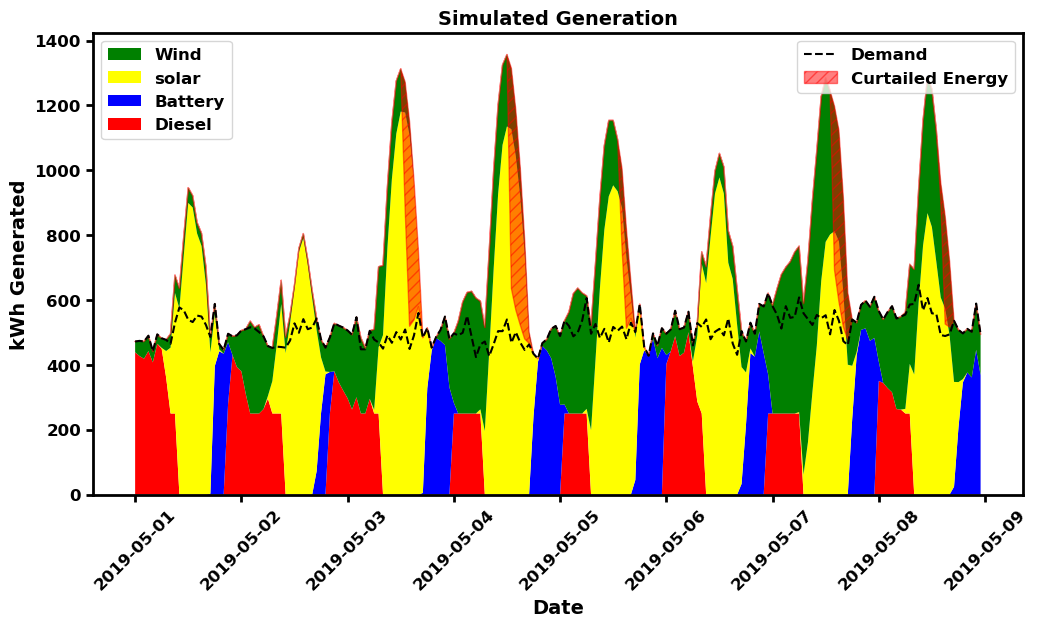

(20239.27346869501, 18061.40185351454, 2177.87161518047)


In [274]:
#plot_generation(simulate_energy(SCIplan), '2019-7-7', '2019-7-14')
plot_generation(simulate_energy(SNIplan), '2019-5-1', '2019-5-8')
print(calculate_carbon(SNIplan))

#print(simulate_energy(8, 4500, 0, 1000, 10000, 1))
#print(simulate_energy(8, 4500, 0, 1000, 10000, 1)['Curtailedcum'].iloc[-1])

# Solely Renewables

4451


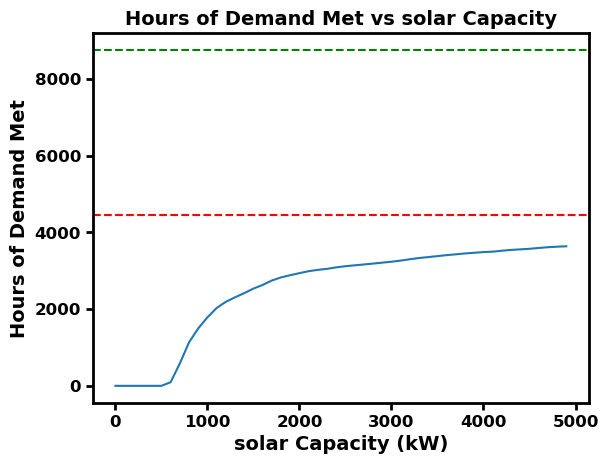

In [275]:
#met demand as solar increases
solsize = np.arange(0, 5000, 100)
hours = []
for i in solsize:
    hours.append(simulate_energy([0, i, 0, 0, 0, 0])['Metdemand'].iloc[-1])
plt.plot(solsize, hours)
plt.xlabel('solar Capacity (kW)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs solar Capacity')
plt.axhline(y=simulate_energy([0, 1000000000000, 0, 0, 0, 0])['Metdemand'].iloc[-1], color='r', linestyle='--')
plt.axhline(y=8760, color='g', linestyle='--')
print(simulate_energy([0, 1000000000000, 0, 0, 0, 0])['Metdemand'].iloc[-1])
plt.show()



7213


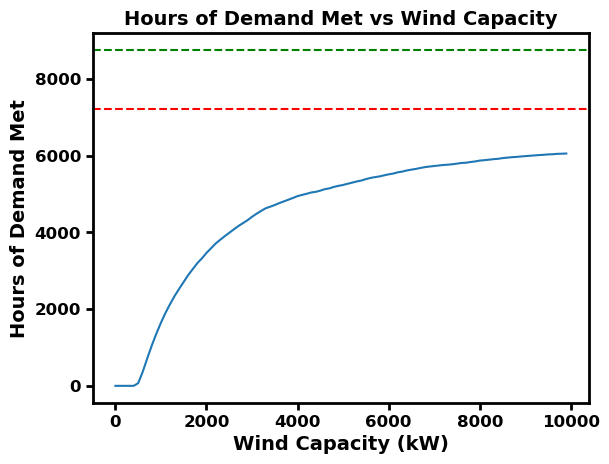

In [276]:
#same for wind
windsize = np.arange(0, 100, 1)
hours = []
for i in windsize:
    hours.append(simulate_energy([i, 0, 0, 0, 0, 0])['Metdemand'].iloc[-1])
plt.plot(windsize*kwperturbine, hours)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs Wind Capacity')
plt.axhline(y=simulate_energy([1000000000000, 0, 0, 0, 0, 0])['Metdemand'].iloc[-1], color='r', linestyle='--')
plt.axhline(y=8760, color='g', linestyle='--')
print(simulate_energy([1000000000000, 0, 0, 0, 0, 0])['Metdemand'].iloc[-1])
plt.show()



15000
8760


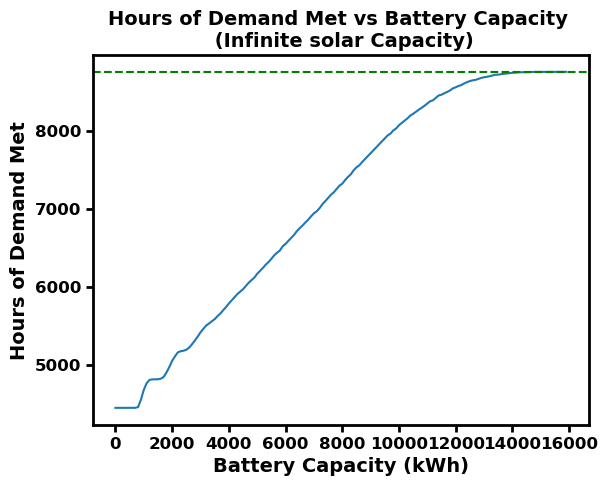

In [326]:
#battery sizing solar
battsize = np.arange(0, 16000, 100)
hours = []
for i in battsize:
    hours.append(simulate_energy([0, 10000000000, 0, 1000, i, 0])['Metdemand'].iloc[-1])
plt.plot(battsize, hours)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs Battery Capacity \n (Infinite solar Capacity)')
plt.axhline(y=8760, color='g', linestyle='--')

#print batt capcity  at first max
print(battsize[np.argmax(hours)])
print(max(hours))

89600
8760


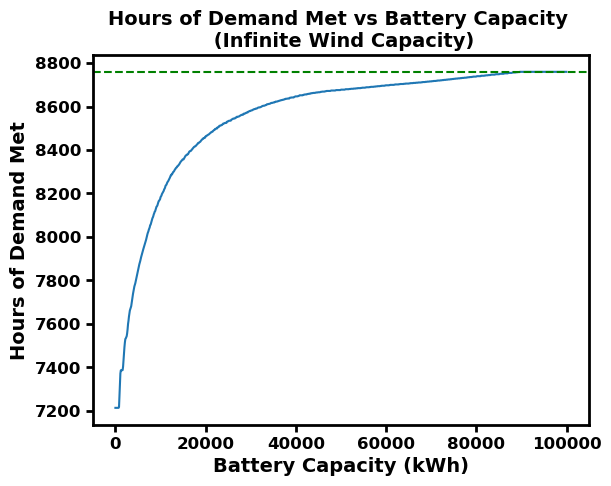

In [327]:
#same for wind
battsize = np.arange(0, 100000, 100)
hours = []
for i in battsize:
    hours.append(simulate_energy([10000000000, 0, 0, 1000, i, 0])['Metdemand'].iloc[-1])
plt.plot(battsize, hours)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs Battery Capacity \n (Infinite Wind Capacity)')
plt.axhline(y=8760, color='g', linestyle='--')
print(battsize[np.argmax(hours)])
print(hours[np.argmax(hours)])
plt.show()


14000
8760


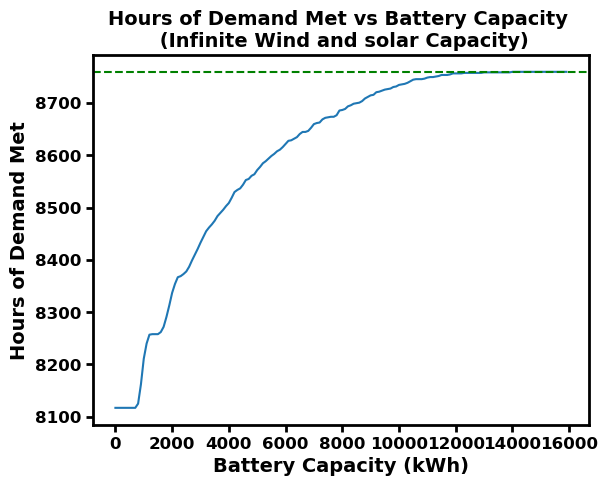

In [328]:
#same for infinite wind and solar
battsize = np.arange(0, 16000, 100)
hours = []
for i in battsize:
    hours.append(simulate_energy([10000000000, 10000000000, 0, 1000, i, 0])['Metdemand'].iloc[-1])
plt.plot(battsize, hours)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs Battery Capacity \n (Infinite Wind and solar Capacity)')
plt.axhline(y=8760, color='g', linestyle='--')
print(battsize[np.argmax(hours)])
print(hours[np.argmax(hours)])
plt.show()


29000
7873


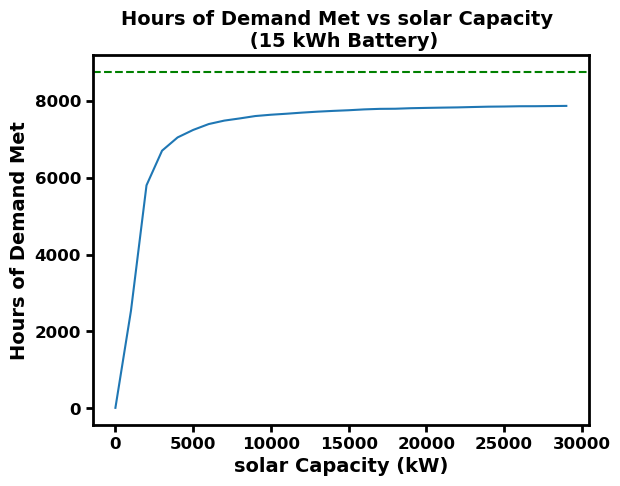

In [280]:
#battery 15 kWh solar scale
solsize = np.arange(0, 30000, 1000)
hours = []
for i in solsize:
    hours.append(simulate_energy([0, i, 0, 1000, 10000, 0])['Metdemand'].iloc[-1])
plt.plot(solsize, hours)
plt.xlabel('solar Capacity (kW)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs solar Capacity \n (15 kWh Battery)')
plt.axhline(y=8760, color='g', linestyle='--')
print(solsize[np.argmax(hours)])
print(hours[np.argmax(hours)])
plt.show()


11800
8760


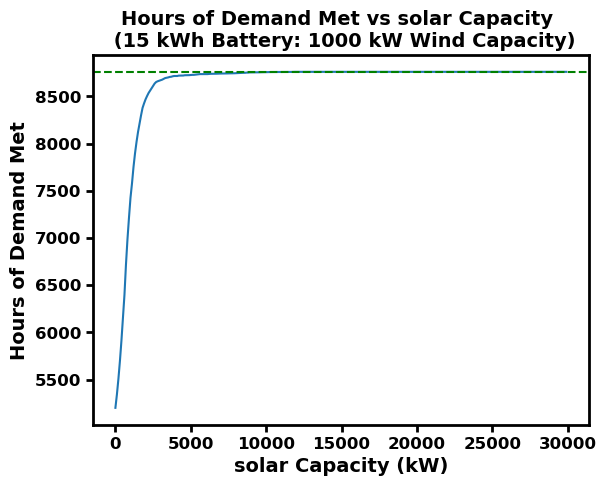

In [331]:
#battery 15 kWh solar scale
solsize = np.arange(0, 30000, 100)
hours = []
for i in solsize:
    hours.append(simulate_energy([20, i, 0, 1000, 20000, 0])['Metdemand'].iloc[-1])
plt.plot(solsize, hours)
plt.xlabel('solar Capacity (kW)')
plt.ylabel('Hours of Demand Met')
plt.title('Hours of Demand Met vs solar Capacity \n (15 kWh Battery: 1000 kW Wind Capacity)')
plt.axhline(y=8760, color='g', linestyle='--')
print(solsize[np.argmax(hours)])
print(hours[np.argmax(hours)])
plt.show()


# Fuel Analysis

800


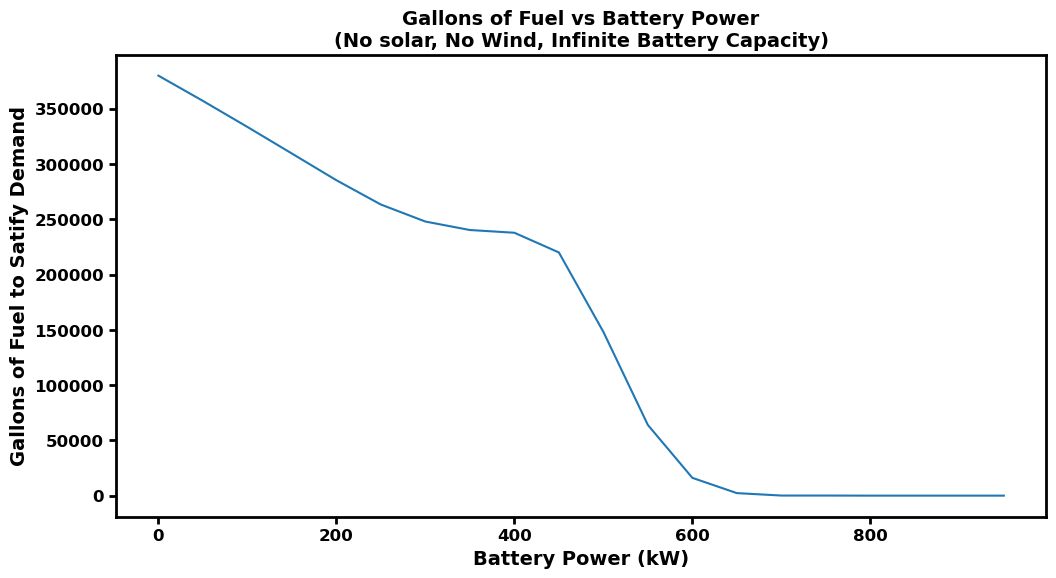

In [282]:
#Battery Power Sizing 
battsize = np.arange(0, 1000, 50)
hours = []
for i in battsize:
    scenario = [0, 0, 0, i, 10000000000000000, 1]
    hours.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battsize, hours)
plt.xlabel('Battery Power (kW)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Battery Power\n(No solar, No Wind, Infinite Battery Capacity)')


#print first value where fuel is minimized
print(battsize[hours.index(min(hours))])
#1300

34500
11500


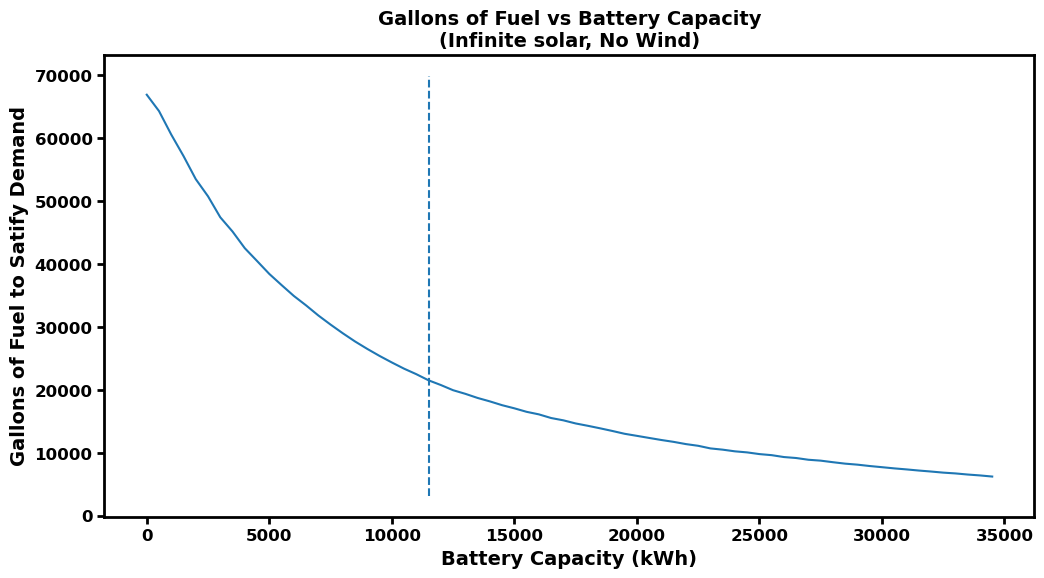

In [283]:
# Battery Capacity Sizing infinite Wind
battcap = np.arange(0, 35000, 500)
hours = []
for i in battcap:
    scenario = [10000000000000, 0, 0, 1000, i, 1]
    hours.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battcap, hours)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Battery Capacity\n(Infinite solar, No Wind)')
#print first value where fuel is minimized
print(battcap[hours.index(min(hours))])
knee_locator = KneeLocator(battcap, hours, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
#print first value where fuel is minimized
print(elbow_point)

15000
11500


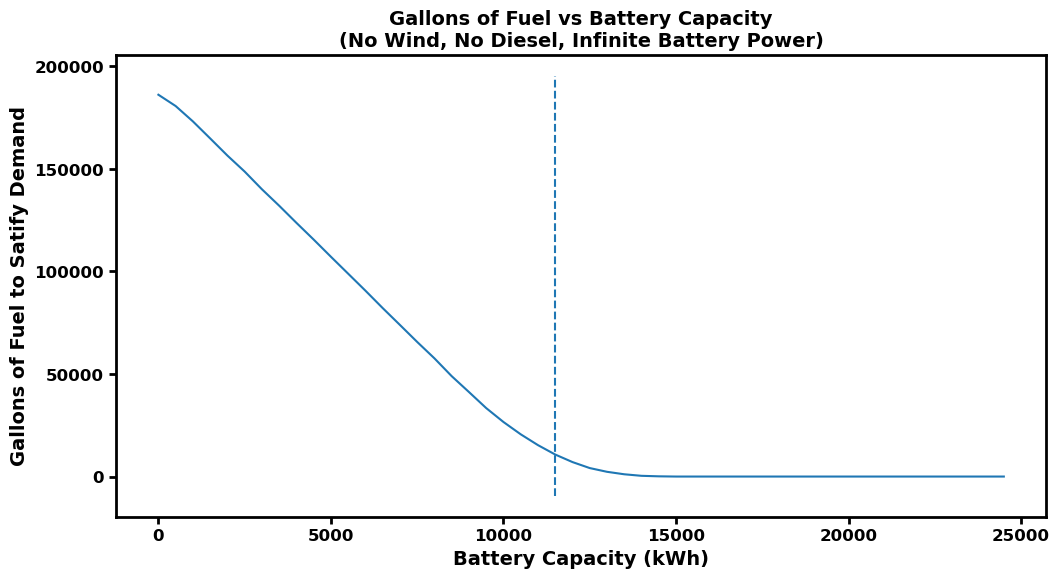

In [284]:
# Battery Capacity Sizing infinite solar
battcap = np.arange(0, 25000, 500)
hours = []
for i in battcap:
    scenario = [0, 10000000000000, 0, 1000, i, 1]
    hours.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battcap, hours)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Battery Capacity\n(No Wind, No Diesel, Infinite Battery Power)')
#print first value where fuel is minimized
print(battcap[hours.index(min(hours))])
knee_locator = KneeLocator(battcap, hours, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#14000

14000
6500


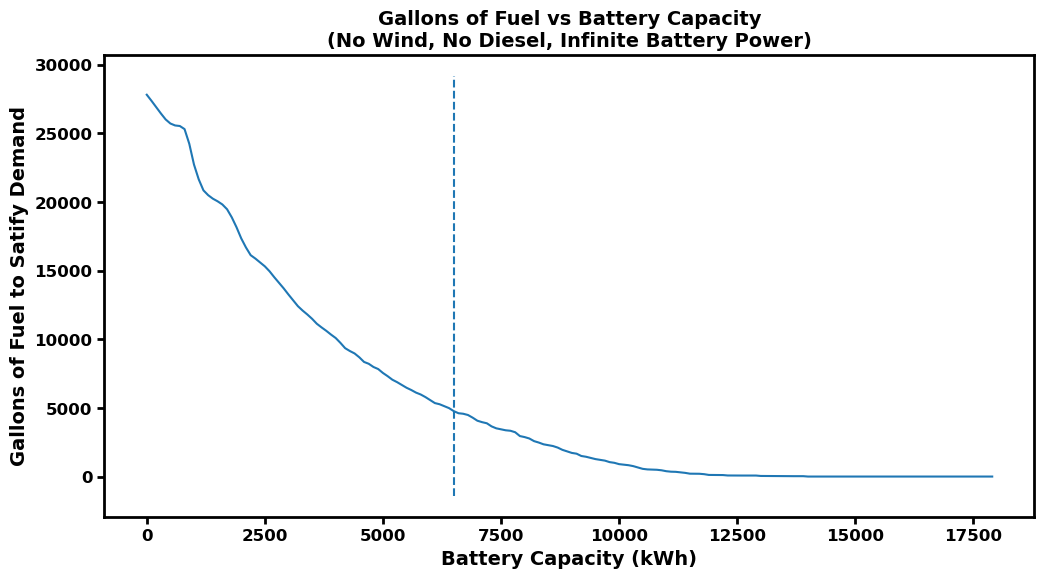

In [285]:
# Battery Capacity Sizing infinite both
battcap = np.arange(0, 18000, 100)
hours = []
for i in battcap:
    scenario = [10000000000000, 10000000000000, 0, 1000, i, 1]
    hours.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])
#plot the data
plt.figure(figsize=(12, 6))
plt.plot(battcap, hours)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Battery Capacity\n(No Wind, No Diesel, Infinite Battery Power)')
#print first value where fuel is minimized
print(battcap[hours.index(min(hours))])
knee_locator = KneeLocator(battcap, hours, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#14000

4000
29000


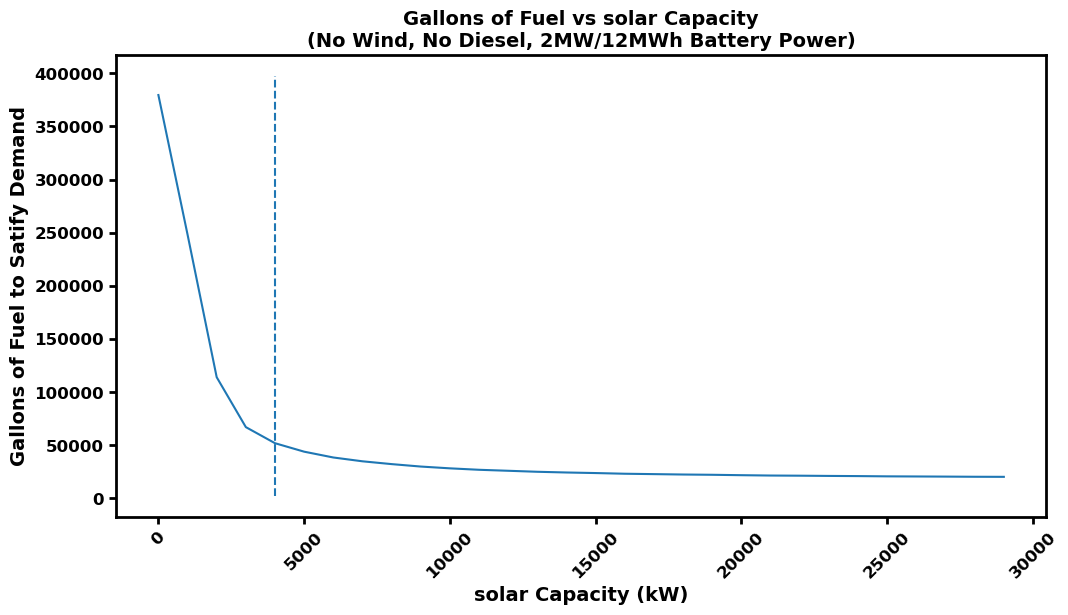

In [286]:
# solar sizing 12MWh battery
solsize = solsize = np.arange(0, 30000, 1000)
fdem = []
for i in solsize:
    scenario = [0, i, 0, 1000, 11000, 1]
    fdem.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('solar Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs solar Capacity\n(No Wind, No Diesel, 2MW/12MWh Battery Power)')

#plot green line at 8760
#plt.axhline(y=8760, color='g', linestyle='--')
knee_locator = KneeLocator(solsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#x axis at an angle
plt.xticks(rotation=45)
print(solsize[fdem.index(min(fdem))])
plt.show()
#find the first value where fuel is minimized
#39000


4000
29000


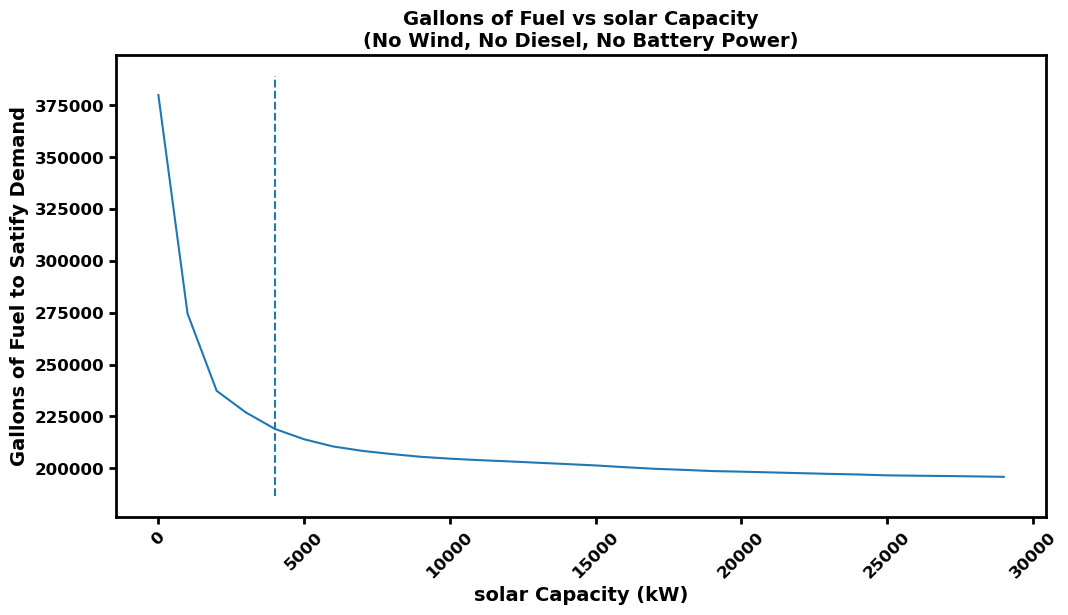

In [287]:
# solar sizing no battery
solsize = solsize = np.arange(0, 30000, 1000)
fdem = []
for i in solsize:
    scenario = [0, i, 0, 0, 0, 1]
    fdem.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('solar Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs solar Capacity\n(No Wind, No Diesel, No Battery Power)')

#plot green line at 8760
#plt.axhline(y=8760, color='g', linestyle='--')
knee_locator = KneeLocator(solsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#x axis at an angle
plt.xticks(rotation=45)
print(solsize[fdem.index(min(fdem))])
plt.show()

29000


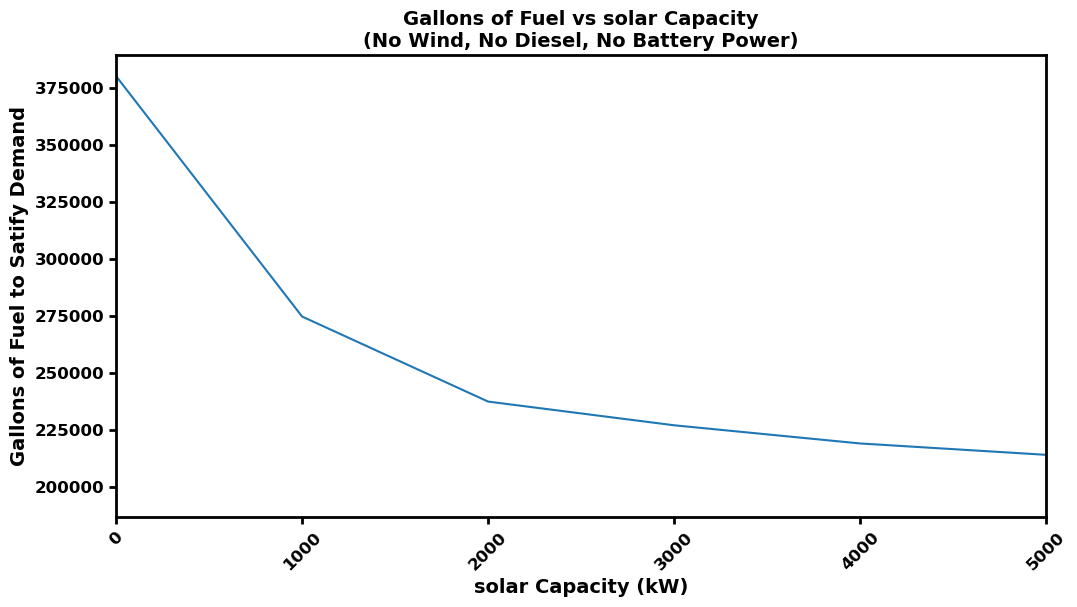

In [288]:
#zoom in up to 5000
plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('solar Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs solar Capacity\n(No Wind, No Diesel, No Battery Power)')
plt.xlim(0, 5000)
plt.xticks(rotation=45)
print(solsize[fdem.index(min(fdem))])

7000
None
490


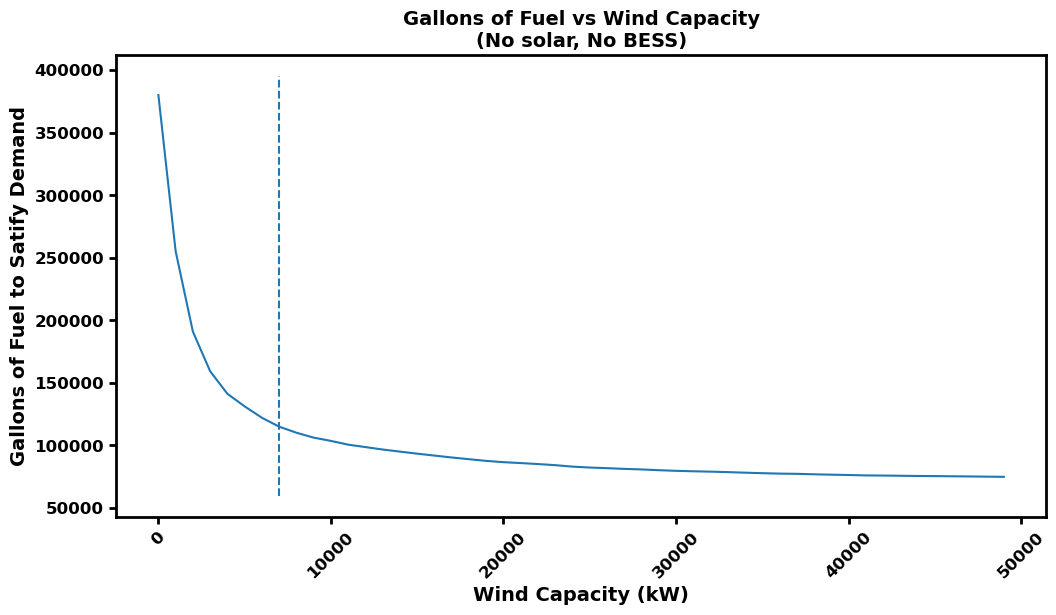

In [289]:
# Wind Sizing no battery
windsize = np.arange(0, 500, 10)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 0, 0, 1]
    fdem.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(windsize*kwperturbine, fdem)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Wind Capacity\n(No solar, No BESS)')

knee_locator = KneeLocator(windsize*kwperturbine, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(find_stable_x(windsize*kwperturbine, fdem), plt.ylim()[0], plt.ylim()[1], linestyles='dotted')
print(elbow_point)
print(find_stable_x(windsize*kwperturbine, fdem))
plt.xticks(rotation=45)
print(windsize[fdem.index(min(fdem))])
plt.show()


3500
195


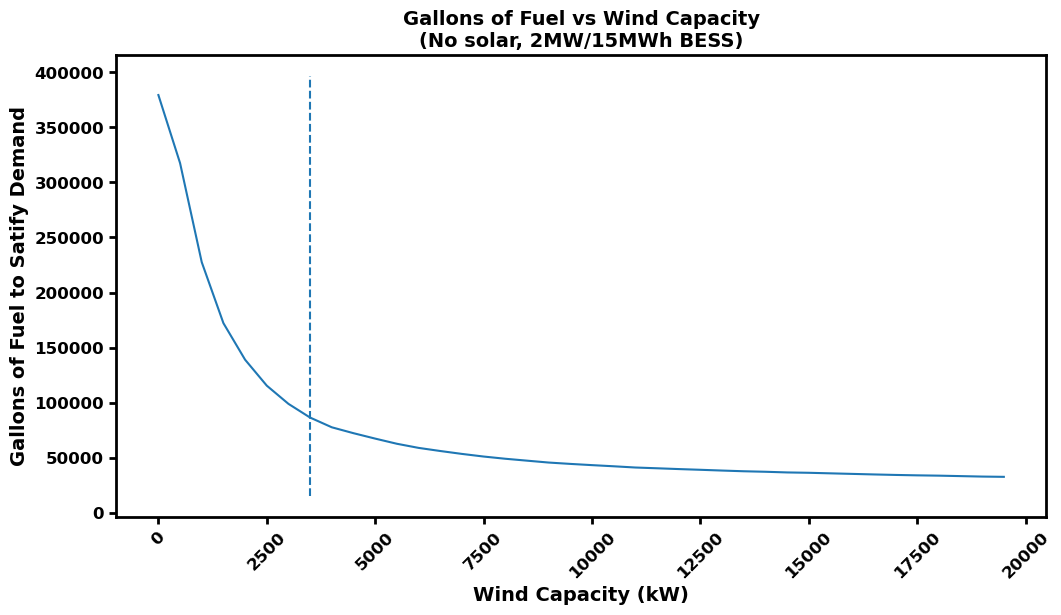

In [290]:
# Wind Sizing 15MWh battery
windsize = np.arange(0, 200, 5)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 1000, 15000, 1]
    fdem.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(windsize*kwperturbine, fdem)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Wind Capacity\n(No solar, 2MW/15MWh BESS)')
knee_locator = KneeLocator(windsize*kwperturbine, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
plt.xticks(rotation=45)
print(windsize[fdem.index(min(fdem))])
plt.show()

49


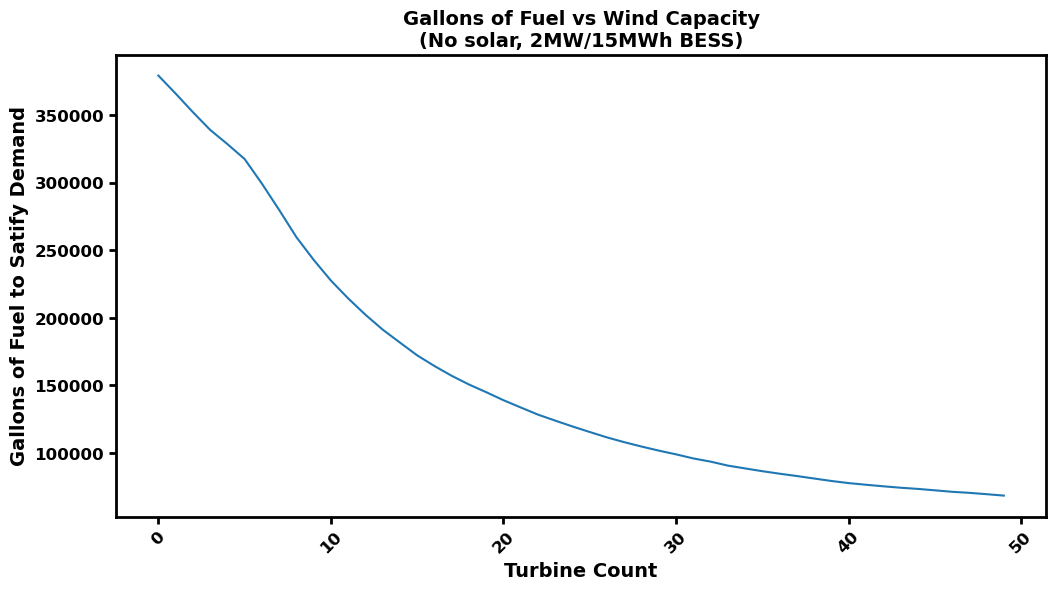

In [291]:
#zoom into 30 turbines
windsize = np.arange(0, 50, 1)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 1000, 15000, 1]
    fdem.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(windsize, fdem)
plt.xlabel('Turbine Count')
plt.ylabel('Gallons of Fuel to Satify Demand')
plt.title('Gallons of Fuel vs Wind Capacity\n(No solar, 2MW/15MWh BESS)')
plt.xticks(rotation=45)
print(windsize[fdem.index(min(fdem))])
plt.show()


# Carbon Analysis

3300
8900


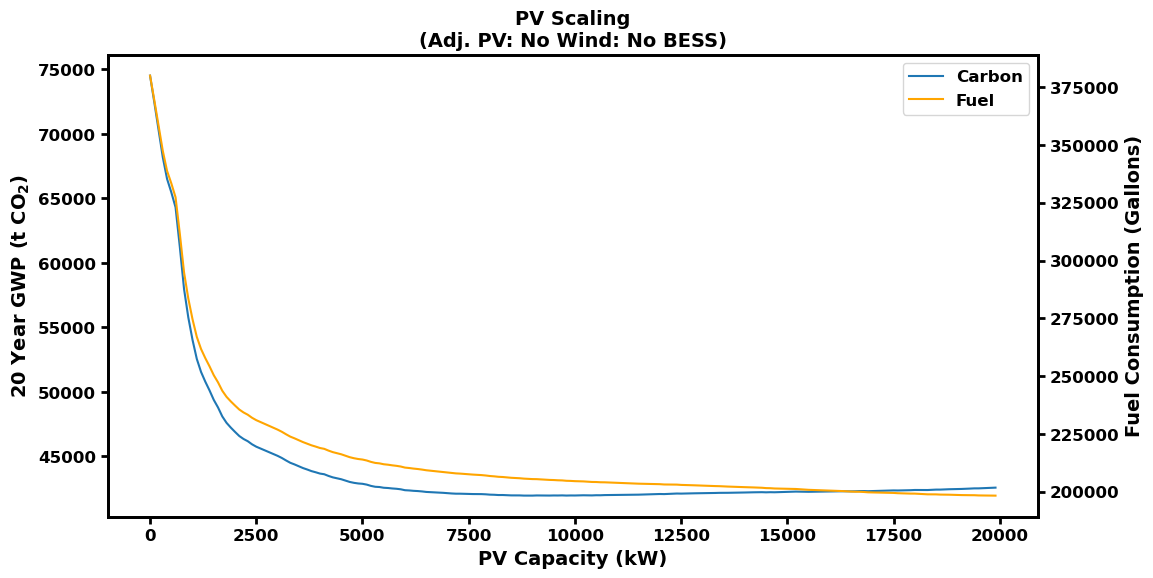

In [317]:
# solar Sizing
# solar Sizing
solsize = np.arange(0, 20000, 100)
cc = []
fdem = []
for i in solsize:
    scenario = [0, i, 0, 0, 0, 1]
    cc.append(calculate_carbon(scenario)[0])
    fdem.append(simulate_energy(scenario)['Fuelcum'].iloc[-1])

plt.figure(figsize=(12, 6))

# Plot carbon on the primary y-axis
line1, = plt.plot(solsize, cc, label='Carbon')
plt.xlabel('PV Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')

# Create a secondary y-axis and plot fuel on it
ax2 = plt.twinx()
line2, = ax2.plot(solsize, fdem, label='Fuel', color='orange')
ax2.set_ylabel('Fuel Consumption (Gallons)')

plt.title('PV Scaling\n(Adj. PV: No Wind: No BESS)')

knee_locator = KneeLocator(solsize, cc, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
#plt.vlines(2000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

print(elbow_point)
#print the solar for lowest emissions
print(solsize[np.argmin(cc)])

# Add a legend for both plots
lines = [line1, line2]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper right')

plt.show()

3300
5400
8900


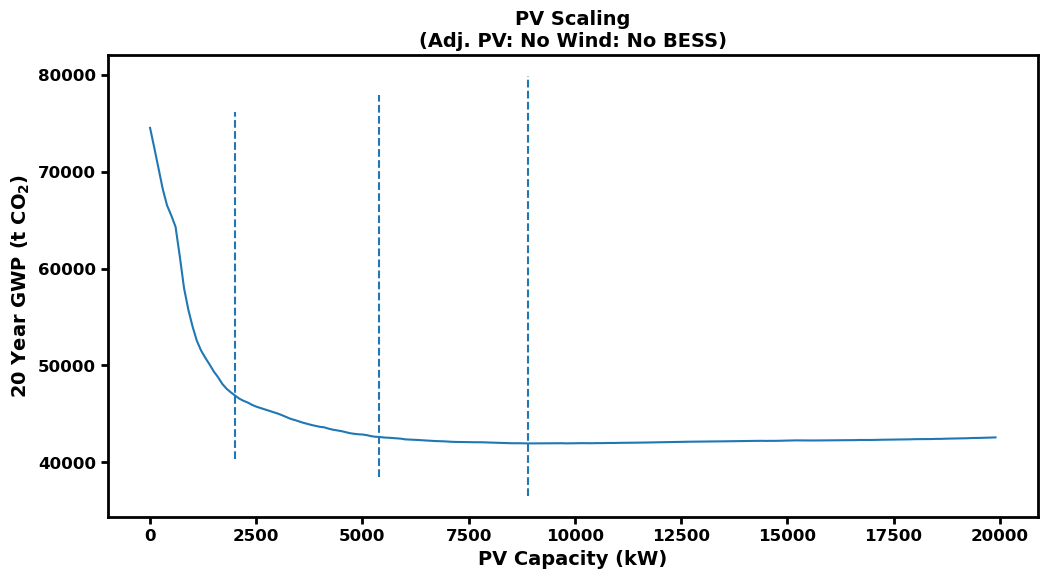

In [316]:
# solar Sizing
# solar Sizing
solsize = np.arange(0, 20000, 100)
cc = []
fdem = []
for i in solsize:
    scenario = [0, i, 0, 0, 0, 1]
    cc.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))

# Plot carbon on the primary y-axis
line1, = plt.plot(solsize, cc, label='Carbon')
plt.xlabel('PV Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')



plt.title('PV Scaling\n(Adj. PV: No Wind: No BESS)')

knee_locator = KneeLocator(solsize, cc, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(2000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(find_stable_x(solsize, cc), plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(solsize[np.argmin(cc)], plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
print(find_stable_x(solsize, cc))
print(solsize[np.argmin(cc)])



plt.show()

3600
8900
11900


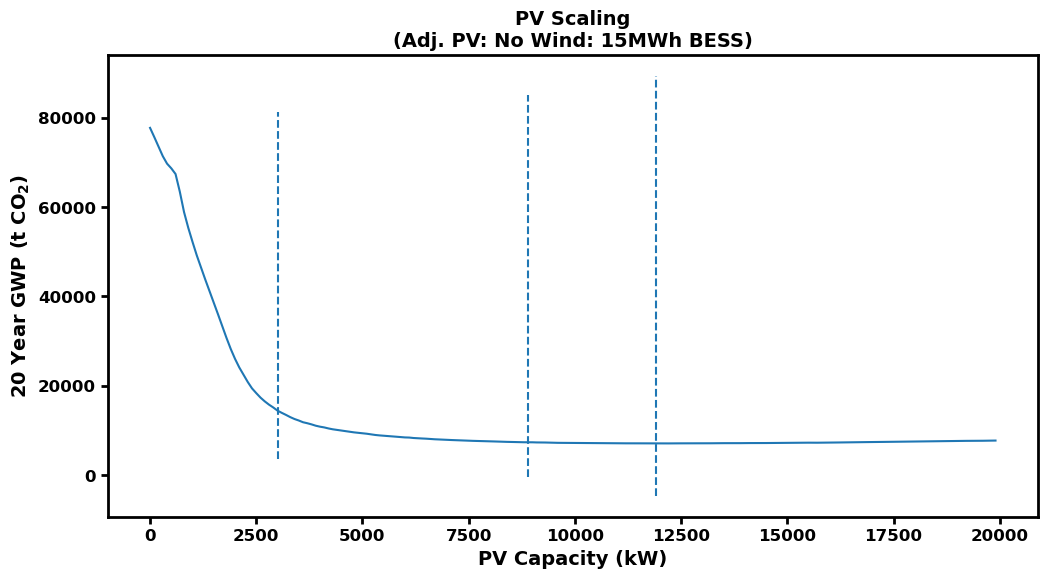

In [325]:
# solar Sizing
# solar Sizing
solsize = np.arange(0, 20000, 100)
cc = []
fdem = []
for i in solsize:
    scenario = [0, i, 0, 1000, 15000, 1]
    cc.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))

# Plot carbon on the primary y-axis
line1, = plt.plot(solsize, cc, label='Carbon')
plt.xlabel('PV Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')



plt.title('PV Scaling\n(Adj. PV: No Wind: 15MWh BESS)')

knee_locator = KneeLocator(solsize, cc, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(3000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(find_stable_x(solsize, cc), plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(solsize[np.argmin(cc)], plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
print(find_stable_x(solsize, cc))
print(solsize[np.argmin(cc)])

In [312]:
#solar 12 kwh battery
solsize = solsize = np.arange(0, 30000, 100)
fdem = []
for i in solsize:
    scenario = [0, i, 0, 1000, 11000, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('PV Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs PV Size\n(Adj. solar: No Wind: 12MWh Battery)')
#print the solar for lowest emissions
print(solsize[np.argmin(fdem)])
knee_locator = KneeLocator(solsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(2400, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)

KeyboardInterrupt: 

85
3000


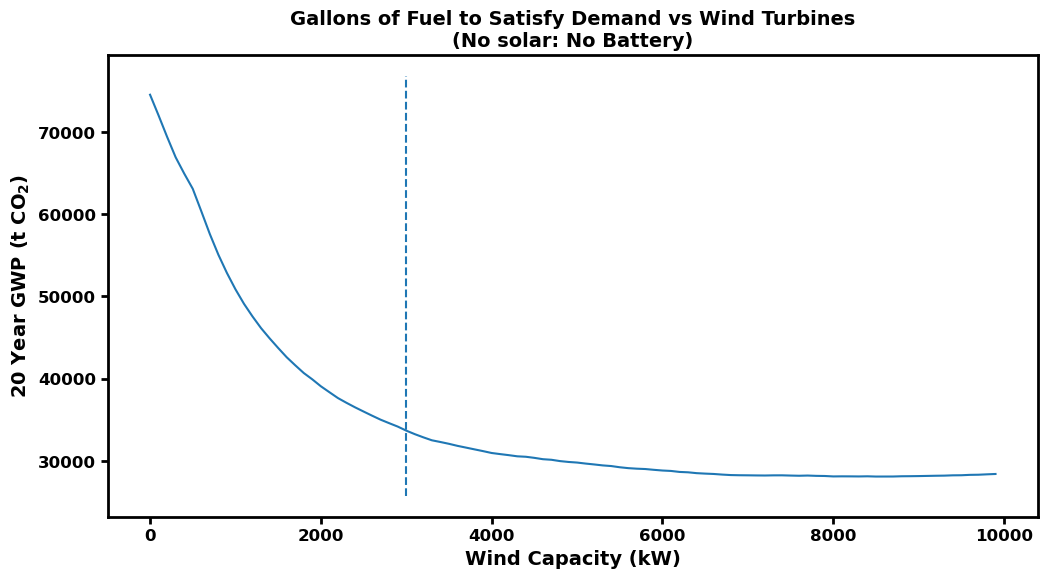

In [294]:
#Wind sizing
windsize = np.arange(0, 100, 1)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 0, 0, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(windsize*kwperturbine, fdem)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Gallons of Fuel to Satisfy Demand vs Wind Turbines\n(No solar: No Battery)')
#print the wind for lowest emissions
print(windsize[np.argmin(fdem)])
knee_locator = KneeLocator(windsize*kwperturbine, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)

73
2400


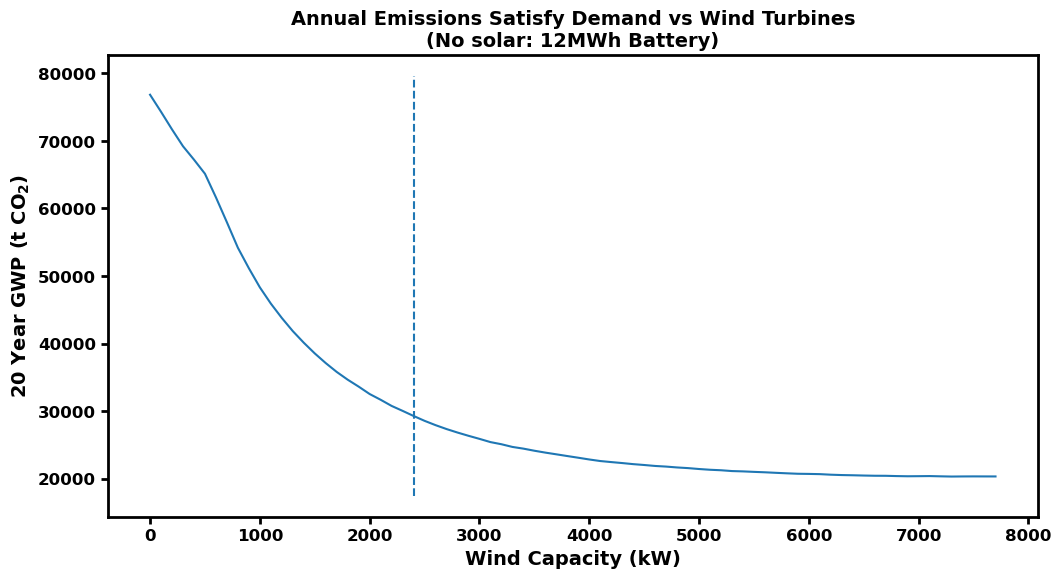

In [295]:
#wind 12 kwh battery
windsize = np.arange(0, 78, 1)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 1000, 11000, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(windsize*kwperturbine, fdem)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Annual Emissions Satisfy Demand vs Wind Turbines\n(No solar: 12MWh Battery)')
#print the wind for lowest emissions
print(windsize[np.argmin(fdem)])
knee_locator = KneeLocator(windsize*kwperturbine, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)

14500
9000
8125904124784.066


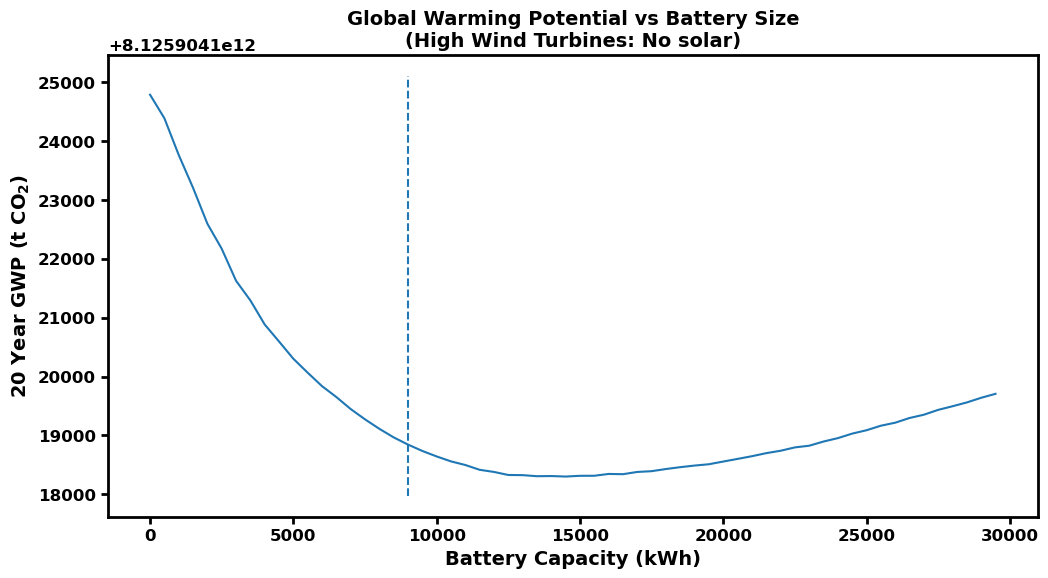

In [296]:
#battery sizing max wind
batsize = np.arange(0, 30000, 500)
fdem = []
for i in batsize:
    scenario = [100000000000, 0, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(High Wind Turbines: No solar)')
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#best battery size for wind 5,000
#print first value in fdem
print(fdem[0])


0
9000


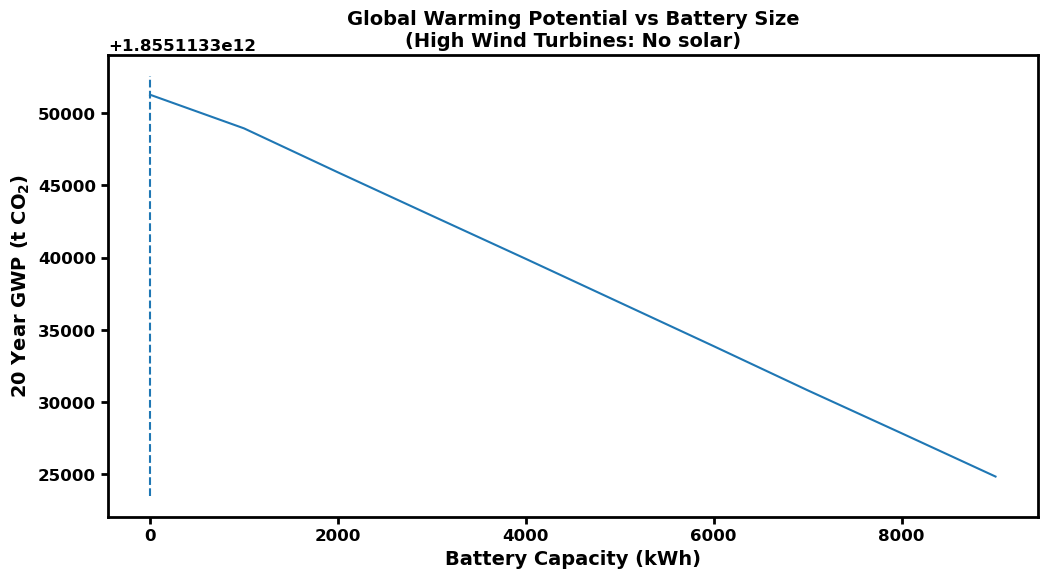

In [297]:
#battery sizing max solar
batsize = np.arange(0, 10000, 1000)
fdem = []
for i in batsize:
    scenario = [0, 10000000000000, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(High Wind Turbines: No solar)')
#print the battery for lowest emissions
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
print(batsize[np.argmin(fdem)])
# best battery benefit at 10,000

4000
9000


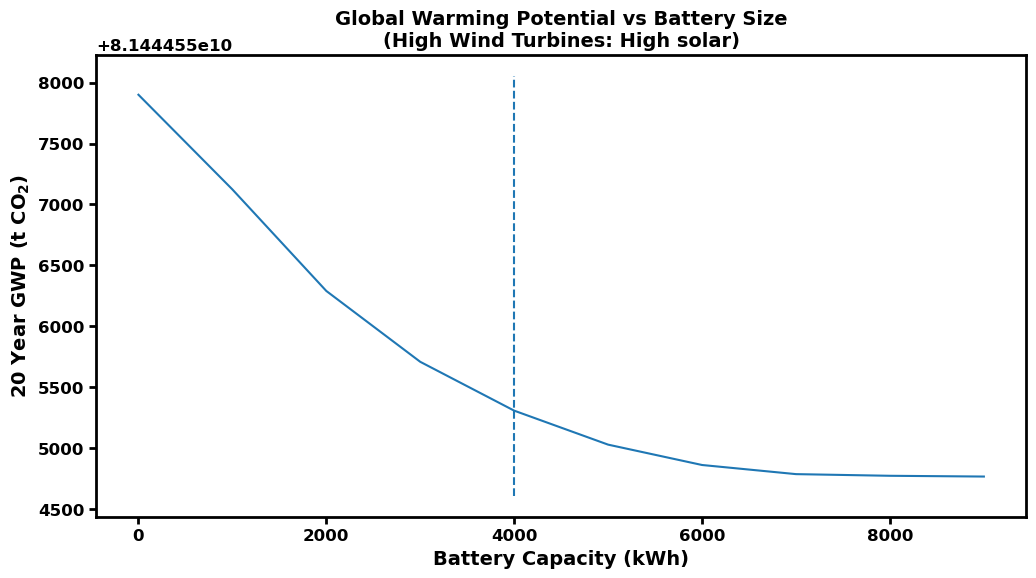

In [298]:
#battery sizing max solar max wind
batsize = np.arange(0, 10000, 1000)
fdem = []
for i in batsize:
    scenario = [1000000000, 1000000000, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(High Wind Turbines: High solar)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

None
9000


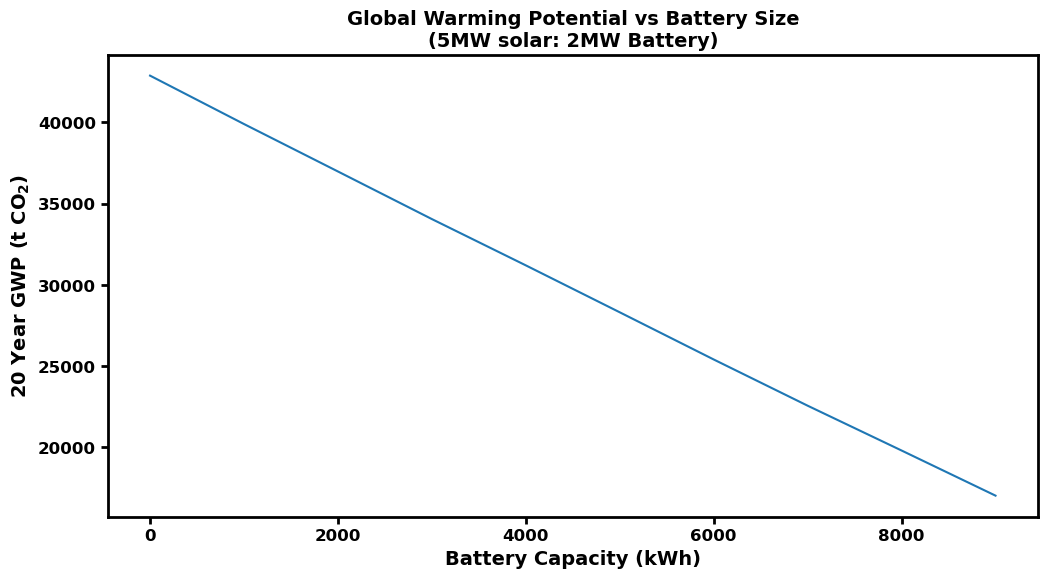

In [299]:
#batt 5000 solar
batsize = np.arange(0, 10000, 1000)
fdem = []
for i in batsize:
    scenario = [0, 5000, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])
    
plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(5MW solar: 2MW Battery)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])


None
9500


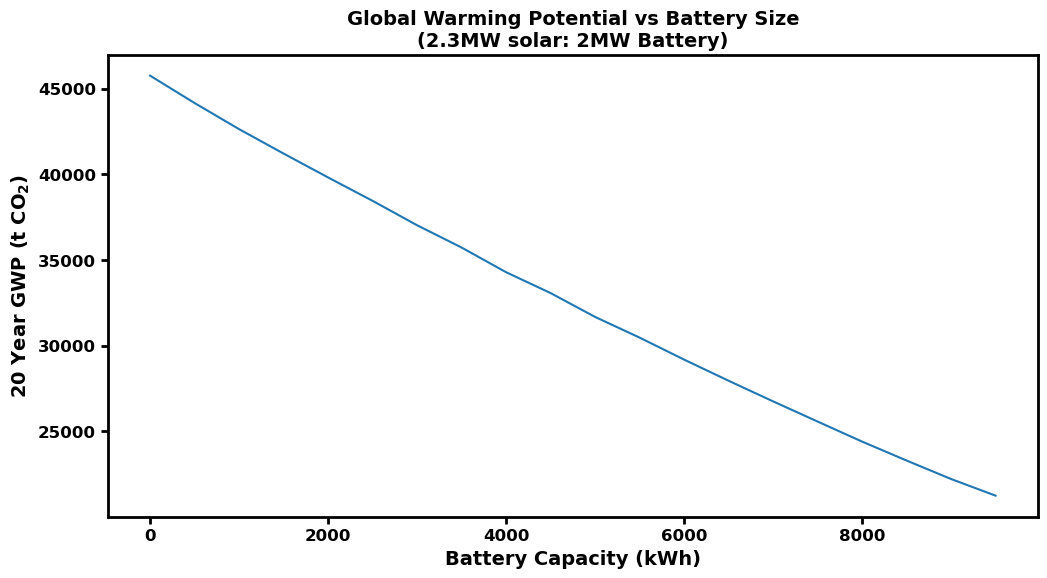

In [300]:
#batt 2300 solar
batsize = np.arange(0, 10000, 500)
fdem = []
for i in batsize:
    scenario = [0, 2500, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(2.3MW solar: 2MW Battery)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])
#best battery benefit at 10,000

10000
31000


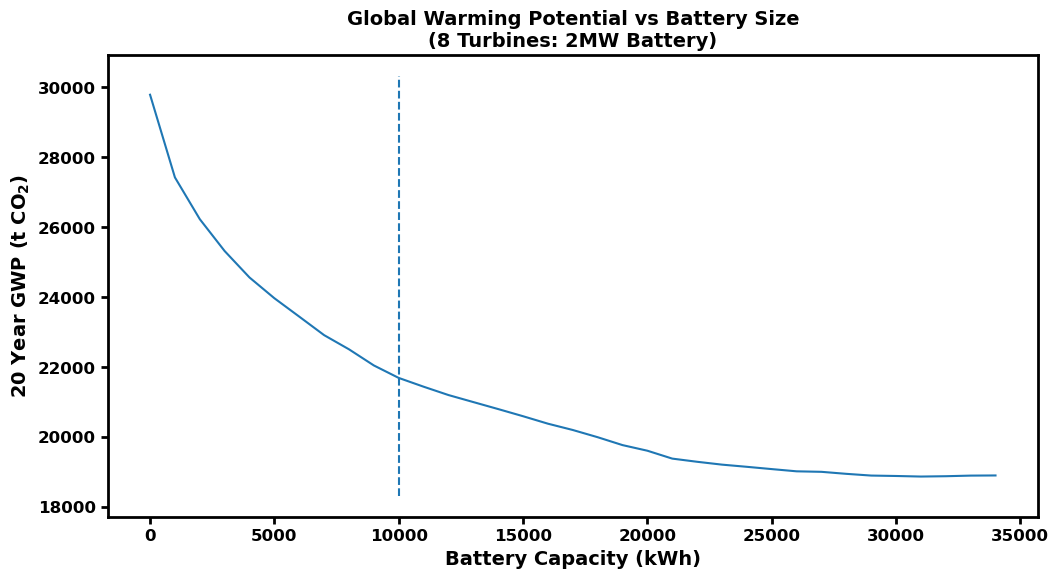

In [301]:
#batt 5000 turbines
batsize = np.arange(0, 35000, 1000)
fdem = []
for i in batsize:
    scenario = [50, 0, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(8 Turbines: 2MW Battery)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])


8000
33000


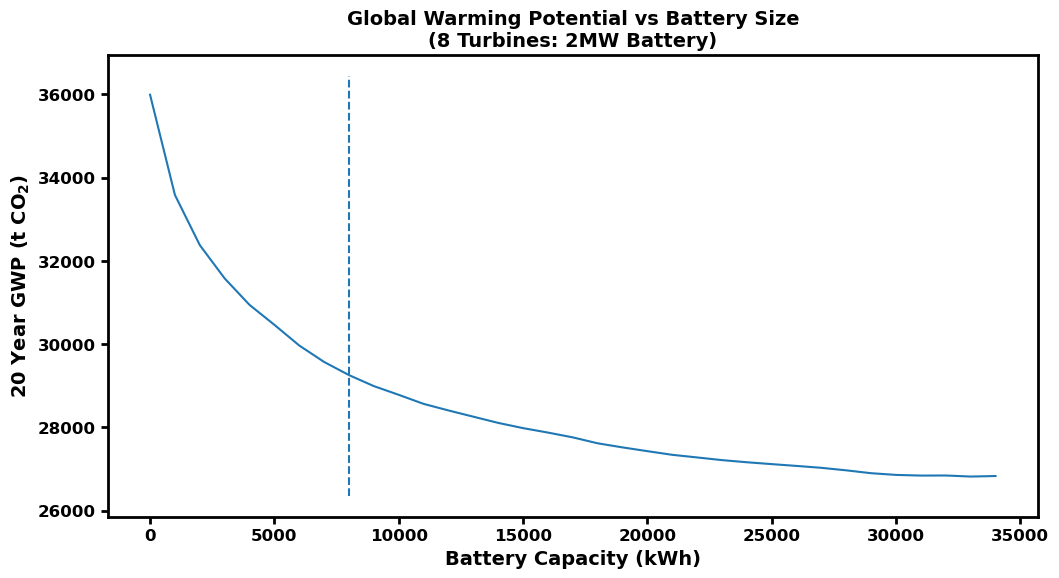

In [302]:
#batt 2500 turbines
batsize = np.arange(0, 35000, 1000)
fdem = []
for i in batsize:
    scenario = [25, 0, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(8 Turbines: 2MW Battery)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

5200
9700


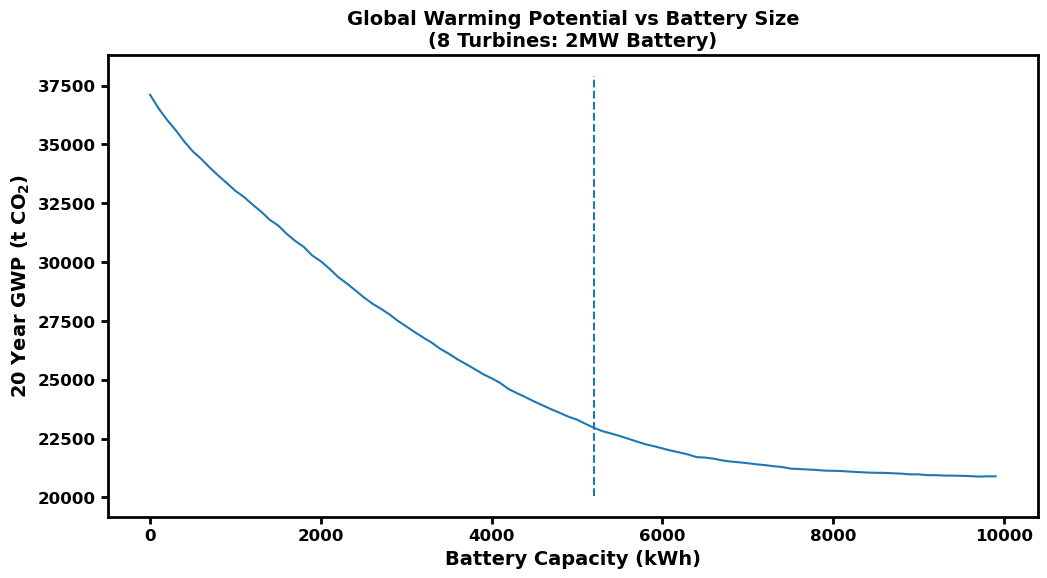

In [303]:
#batt 8 turbines 1000 solar
batsize = np.arange(0, 10000, 100)
fdem = []
for i in batsize:
    scenario = [7, 1450, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(8 Turbines: 2MW Battery)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

5000
9800


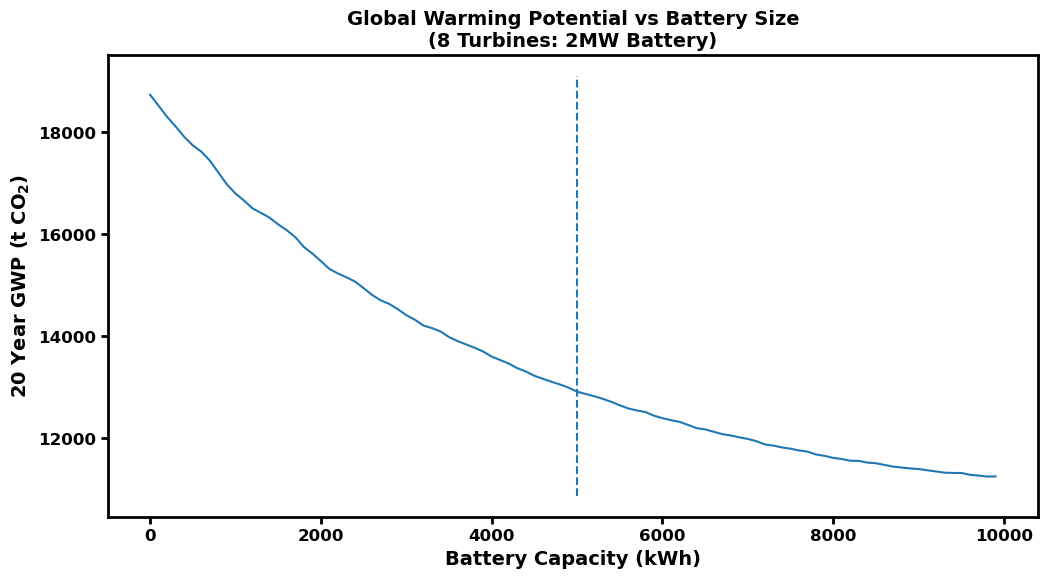

In [304]:
#scenario
batsize = np.arange(0, 10000, 100)
fdem = []
for i in batsize:
    scenario = [80,10000, 0, 1000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year GWP (t CO$_2$)')
plt.title('Global Warming Potential vs Battery Size\n(8 Turbines: 2MW Battery)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

# Scenarios

### Renewable Grid


6778.4654486323025
1413.5405750298462
5364.9248736024565


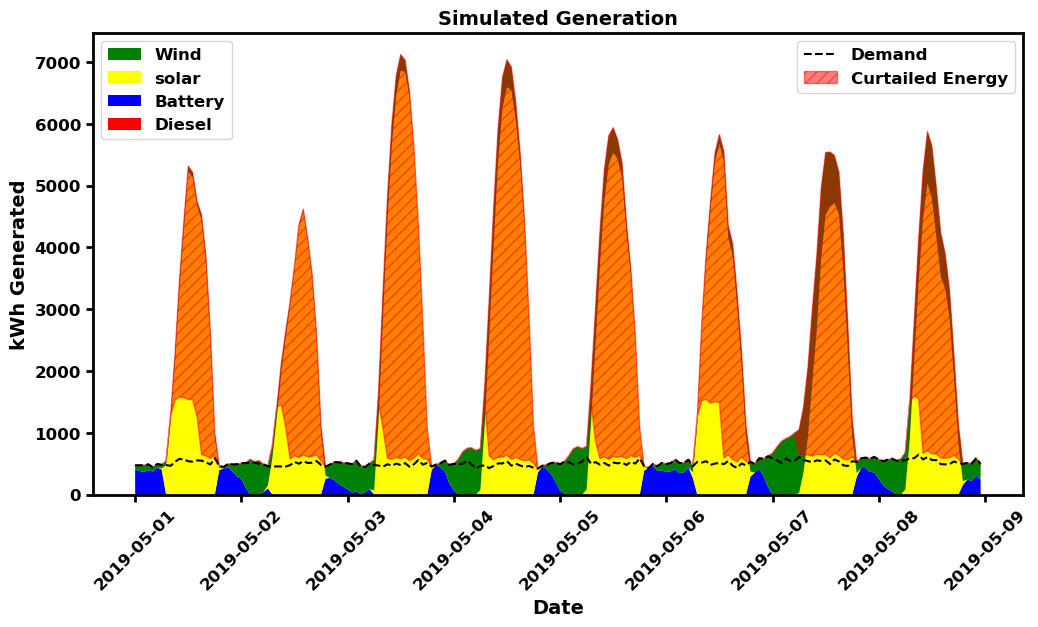

In [305]:
renewableonly = [20, 8300, 0,1000,10000,1]
print(calculate_carbon(renewableonly)[0])
print(calculate_carbon(renewableonly)[1])
print(calculate_carbon(renewableonly)[2])
plot_generation(simulate_energy(renewableonly), '2019-5-1', '2019-5-8')

8484.993716537452
5.3142244975027415
8479.679492039948


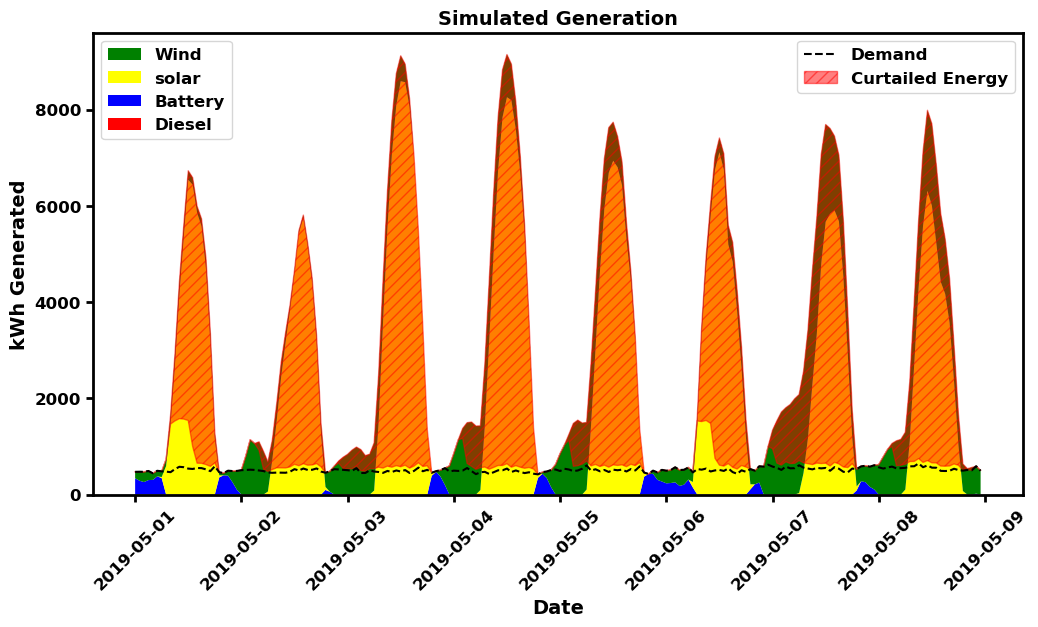

In [306]:
renewableonly = [40, 10400, 0,1000,15000,1]
print(calculate_carbon(renewableonly)[0])
print(calculate_carbon(renewableonly)[1])
print(calculate_carbon(renewableonly)[2])
plot_generation(simulate_energy(renewableonly), '2019-5-1', '2019-5-8')

### solar

54027.41612242396
53841.90479094573
185.51133147822


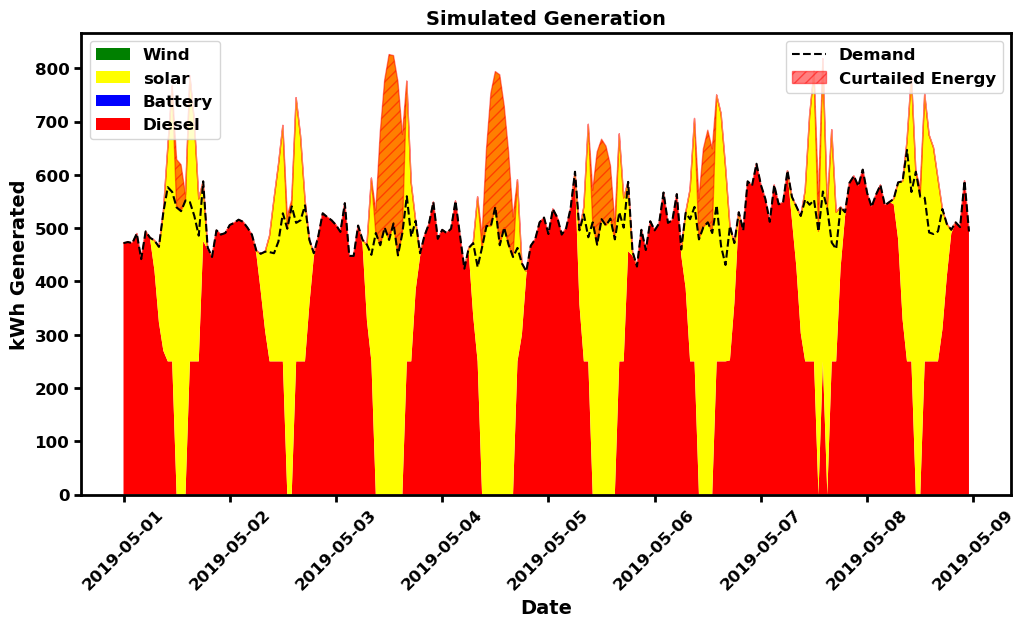

In [307]:
solar = [0, 1000, 0,0, 0,1]
print(calculate_carbon(solar)[0])
print(calculate_carbon(solar)[1])
print(calculate_carbon(solar)[2])
plot_generation(simulate_energy(solar), '2019-5-1', '2019-5-8')

### Wild

(30951.203938706363, 27700.842294039907, 3250.361644666461)


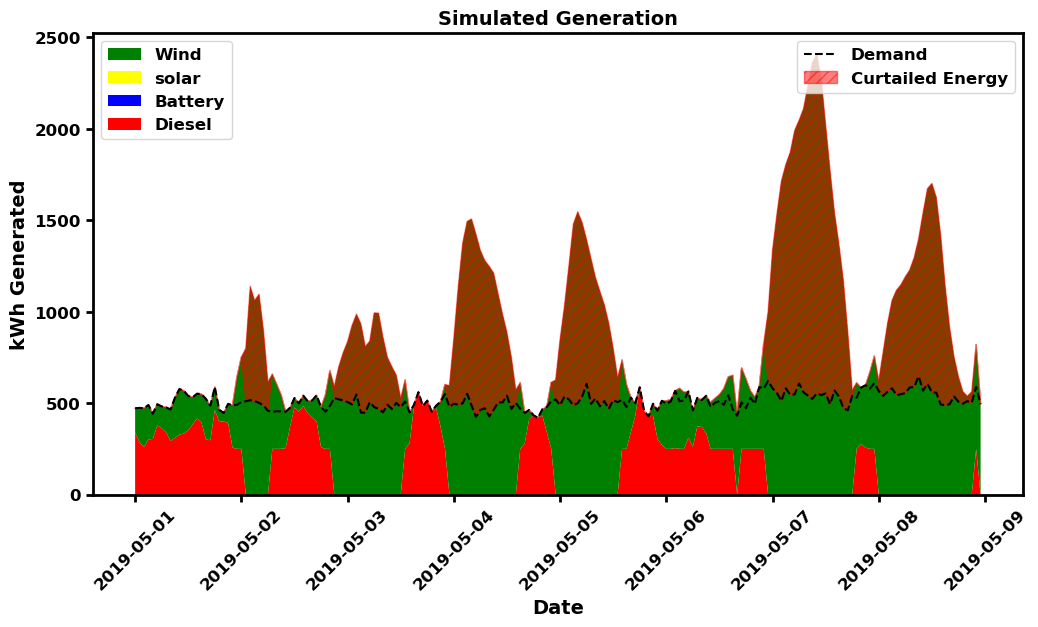

In [308]:
wind = [40, 0, 0,0, 0,1]
print(calculate_carbon(wind))
plot_generation(simulate_energy(wind), '2019-5-1', '2019-5-8')

### Wind + BESS

(21785.83931950631, 15235.477674839847, 6550.361644666461)


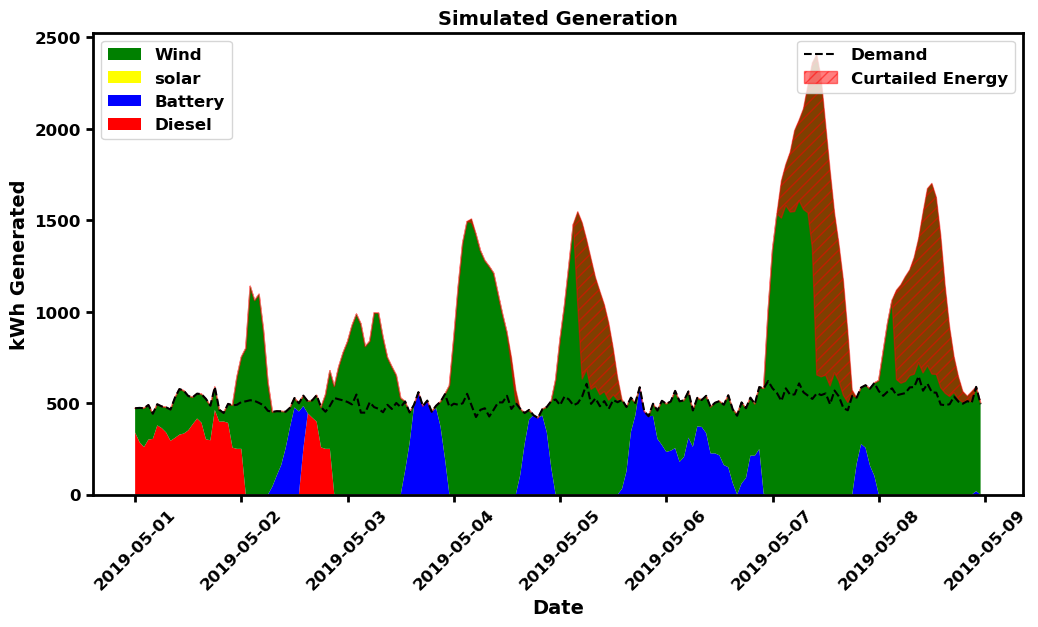

In [309]:
windBESS = [40, 0, 0,1000, 15000,1]
print(calculate_carbon(windBESS))
plot_generation(simulate_energy(windBESS), '2019-5-1', '2019-5-8')

### solar + BESS

(11803.29419185245, 7835.453398530858, 3967.8407933215917)


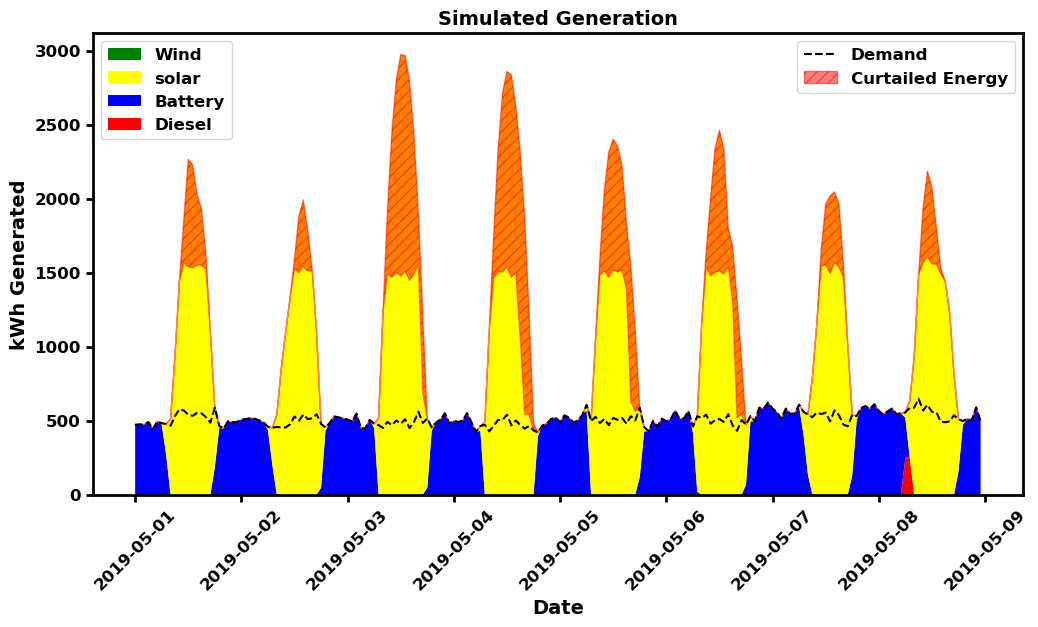

In [310]:
solarBESS = [0, 3600, 0,1000, 15000,1]
print(calculate_carbon(solarBESS))
plot_generation(simulate_energy(solarBESS), '2019-5-1', '2019-5-8')

### solar + Wind + BESS